# Problem Satement

The goal is to help The Department of Housing and Development manage 311 complaints that are not necessarily urgent. Large volumes of complaints are impacting the overall operations of the agency.

The agency is looking to manage the large volume of complaints by answering the following quastions:

1. Which type of complaint should be focused on 
2. Are there any particular boroughs that should be focused on due to this type of complaint
3. Does the complaint type have any obvious relationships with characteristics of the buildings
4. can we build a predictive model to be built for future prediciton of the complaint type

In [ ]:
#if Folium Libraries don't Load
# """!conda install -c conda-forge folium=0.11.0 --yes """

In [ ]:
# !pip install plotly.express

In [1]:
import pandas as pd
import json
import math
import plotly.express as px
import numpy as np
from sklearn import neighbors

from folium import plugins

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

## Load Data

In [2]:
Orig_HBD = pd.read_csv("311_Service_Requests_from_2010_to_Present_min.csv")

In [36]:
Orig_HBD.shape

(6019843, 16)

We can see there is 6,019,843 samples and 16 features or columns

### Column Descriptions

**Uunique Key:** Uniques identifier of Service Requests(SR) in open dataset

**Created Date:** Date SR was requested

**Closed Date:** Date SR was closed by responding agency

**Complaint Type:** This is the first lvl of hierarchy identifying the topic of the incident or condition. May have corresponding descriptor or not.

**Location Type:** Describes the type of location used in the address information.

**Incident Zip:** Zip code, provided by geo validation.

**Incident Address:** House number of incident address provided by submitter.

**Street Name:** Street name of incident.

**Address Type:** The type of incident location information available.

**City:** City of the incident.

**Status:** Status of SR submitted.

**Resolution Description:** Describes last action taken on the SR by the responding agency. May describe next or future steps.

**Borough:** Self described.

**Latitude:** Self described.

**Longitiude:** Self described.

In [37]:
Orig_HBD.head()

,Unnamed: 0,Unique Key,Created Date,Closed Date,Complaint Type,Location Type,Incident Zip,Incident Address,Street Name,Address Type,City,Status,Resolution Description,Borough,Latitude,Longitude
0,0,45531130,02/02/2020 06:09:17 AM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10019.00,426 WEST 52 STREET,WEST 52 STREET,ADDRESS,NEW YORK,Open,The following complaint conditions are still o...,MANHATTAN,40.77,-73.99
1,1,45529784,02/02/2020 02:15:24 PM,NaN,UNSANITARY CONDITION,RESIDENTIAL BUILDING,11204.00,1751 67 STREET,67 STREET,ADDRESS,BROOKLYN,Open,The following complaint conditions are still o...,BROOKLYN,40.62,-73.99
2,2,45527528,02/02/2020 02:27:41 AM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,11372.00,87-15 37 AVENUE,37 AVENUE,ADDRESS,Jackson Heights,Open,The following complaint conditions are still o...,QUEENS,40.75,-73.88
3,3,45530329,02/02/2020 12:13:18 PM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10458.00,2405 SOUTHERN BOULEVARD,SOUTHERN BOULEVARD,ADDRESS,BRONX,Open,The following complaint conditions are still o...,BRONX,40.85,-73.88
4,4,45528814,02/02/2020 01:59:44 PM,NaN,APPLIANCE,RESIDENTIAL BUILDING,11209.00,223 78 STREET,78 STREET,ADDRESS,BROOKLYN,Open,The following complaint conditions are still o...,BROOKLYN,40.63,-74.03


Off the bat we saee there are some missing data in the `Closed Date` column.

In [38]:
Na = Orig_HBD.isnull().sum()
Na

Unnamed: 0                     0
Unique Key                     0
Created Date                   0
Closed Date               126657
Complaint Type                 0
Location Type              52824
Incident Zip               80697
Incident Address           52825
Street Name                52825
Address Type               84765
City                       80274
Status                         0
Resolution Description      7826
Borough                        0
Latitude                   80671
Longitude                  80671
dtype: int64

We will come back to the missing Data and right now focus on the two Features that are the focus of our attention: `Complaint Type` and `Borough` which have no missing data.

## Data PreProcessing and Selection

I'm going to create another dataframe with the columns the will be usefull in determining the Answer to Question 1: Which Complaint Type should the Agency focus on first.

But first I'm going to rename the columns for simplicity sake.

In [3]:
HBD = Orig_HBD.rename(columns={'Complaint Type':'Complaint_Type', 'Incident Zip':'Incident_Zip',
                               'Unique Key':'Unique_Key', 'Created Date':'Created_Date','Closed Date':'Closed_Date',
                               'Location Type':'Location_Type','Address Type':'Address_Type', 'Street Name':'Street_Name'})

#### Going to explore the `Complaint_Type` feature.

In [4]:
HBD['Complaint_Type'].value_counts()

HEAT/HOT WATER            1261574
HEATING                    887850
PLUMBING                   711130
GENERAL CONSTRUCTION       500863
UNSANITARY CONDITION       451643
PAINT - PLASTER            361257
PAINT/PLASTER              346438
ELECTRIC                   307310
NONCONST                   260890
DOOR/WINDOW                205278
WATER LEAK                 193631
GENERAL                    151308
FLOORING/STAIRS            137402
APPLIANCE                  112831
HPD Literature Request      52824
SAFETY                      51529
OUTSIDE BUILDING             7142
ELEVATOR                     6725
Unsanitary Condition         5499
CONSTRUCTION                 5078
General                      1163
Safety                        424
STRUCTURAL                     16
Plumbing                       11
AGENCY                          9
VACANT APARTMENT                6
Outside Building                6
Appliance                       4
Electric                        1
Mold          

We can see there are a couple of issues with the unique values found in the Complaint_Type column. First, there are duplicates in both Upper and Lower case. So we need to correct that in order to combine those two unique values. To do so I just used the `str.upper()` function.

In [5]:
HBD['Complaint_Type']=HBD['Complaint_Type'].str.upper()
HBD.replace("PAINT - PLASTER", "PAINT/PLASTER", inplace=True)

In [6]:
HBD['Complaint_Type'].value_counts()

HEAT/HOT WATER            1261574
HEATING                    887850
PLUMBING                   711141
PAINT/PLASTER              707695
GENERAL CONSTRUCTION       500863
UNSANITARY CONDITION       457142
ELECTRIC                   307311
NONCONST                   260890
DOOR/WINDOW                205278
WATER LEAK                 193631
GENERAL                    152471
FLOORING/STAIRS            137402
APPLIANCE                  112835
HPD LITERATURE REQUEST      52824
SAFETY                      51953
OUTSIDE BUILDING             7148
ELEVATOR                     6725
CONSTRUCTION                 5078
STRUCTURAL                     16
AGENCY                          9
VACANT APARTMENT                6
MOLD                            1
Name: Complaint_Type, dtype: int64

#### Lets look at the top 5 Complaint Types.

In [7]:
HBD['Complaint_Type'].value_counts().iloc[:5]

HEAT/HOT WATER          1261574
HEATING                  887850
PLUMBING                 711141
PAINT/PLASTER            707695
GENERAL CONSTRUCTION     500863
Name: Complaint_Type, dtype: int64

In [8]:
HBD['Complaint_Type'].describe()

count            6019843
unique                22
top       HEAT/HOT WATER
freq             1261574
Name: Complaint_Type, dtype: object

It looks like the Complaint Type with the highest volume is HEAT/HOT WATER.

In [ ]:
#Convert to datetime
HBD['Created_Date'] = pd.to_datetime(HBD['Created_Date'])

#### Let's explore the data further and look at the difference of Complaint types over the years

In [ ]:
Dates_14vCur = HBD[(HBD.Created_Date.dt.strftime("%Y") >='2014')]

In [ ]:
Dates_14vCur['Complaint_Type'].value_counts()

In [ ]:
Dates_v13 = HBD[(HBD.Created_Date.dt.strftime("%Y") <= '2013')]

In [ ]:
Dates_v13['Complaint_Type'].value_counts()

It seems some new complaint Types were added after 2014. Upon further research it appears HEATING has been converted to HEAT/HOT WATER so now we will merge those two unique types. 

In [139]:
HBD.replace("HEATING", "HEAT/HOT WATER", inplace=True)

## Save to csv
HBD.to_csv('HBD_v1.csv')

Lets look at the Cases that have been closed vs the cases that are open

#### Closed Cases

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

Let's take a look again at those null counts

In [ ]:
Na

Looks like there is 126,657 samples with Null data in Closed_Date. So because open cases don't have closed dates these will be the cases that are open and samples with a closed date are cases that are closed

In [ ]:
HBD_Closed = HBD.dropna(subset=["Closed_Date"], axis=0)
HBD_Closed['Complaint_Type'].value_counts()

In [ ]:
pd.notna('Closed_Date')

In [ ]:
HBD_Closed.Complaint_Type.value_counts().plot(kind='bar',
                                             figsize=(10,5))

In [ ]:
HBD_Open = HBD[(HBD['Closed_Date'].isnull())]
HBD_Open['Complaint_Type'].value_counts()

In [ ]:
HBD_Open.Complaint_Type.value_counts().plot(kind='bar', figsize=(10,5))

So it look like the complaints that get tended to first are vastly different than the ones that are still open. 

But since the Problem Statement is focusing on Volume of complaints and not necessarily focusing on handling the current cases that are open, the complaint type we will be focusing on is HEAT/HOT WATER since it is has the largest volume by far. 

## Exploring  Complaint Type and Borough

In [9]:
HBD_Boro = HBD[(HBD['Complaint_Type'] == 'HEAT/HOT WATER')]
HBD_Boro.head()

,Unnamed: 0,Unique_Key,Created_Date,Closed_Date,Complaint_Type,Location_Type,Incident_Zip,Incident Address,Street_Name,Address_Type,City,Status,Resolution Description,Borough,Latitude,Longitude
0,0,45531130,02/02/2020 06:09:17 AM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10019.0,426 WEST 52 STREET,WEST 52 STREET,ADDRESS,NEW YORK,Open,The following complaint conditions are still o...,MANHATTAN,40.765132,-73.988993
2,2,45527528,02/02/2020 02:27:41 AM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,11372.0,87-15 37 AVENUE,37 AVENUE,ADDRESS,Jackson Heights,Open,The following complaint conditions are still o...,QUEENS,40.750269,-73.879432
3,3,45530329,02/02/2020 12:13:18 PM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10458.0,2405 SOUTHERN BOULEVARD,SOUTHERN BOULEVARD,ADDRESS,BRONX,Open,The following complaint conditions are still o...,BRONX,40.853773,-73.881558
5,5,45530344,02/02/2020 07:52:08 AM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10456.0,1131 MORRIS AVENUE,MORRIS AVENUE,ADDRESS,BRONX,Open,The following complaint conditions are still o...,BRONX,40.831381,-73.915218
7,7,45527939,02/02/2020 09:00:54 AM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,11372.0,37-20 81 STREET,81 STREET,ADDRESS,Jackson Heights,Open,The following complaint conditions are still o...,QUEENS,40.749320,-73.885190


In [46]:
HBD_Boro.shape

(1261574, 16)

#### Let's remove the columns that are not going to be useful as we explore the relationship between Complaint Type and Borough.

In [10]:
HBD_Boro = HBD_Boro.drop(['Unnamed: 0','Closed_Date','Location_Type',
               'Status','Resolution Description','City','Address_Type'], axis=1)

In [11]:
HBD_Boro.isnull().sum()

Unique_Key             0
Created_Date           0
Complaint_Type         0
Incident_Zip        7116
Incident Address       0
Street_Name            0
Borough                0
Latitude            7115
Longitude           7115
dtype: int64

In [12]:
HBD_Boro.Borough.value_counts()

BRONX            410853
BROOKLYN         384523
MANHATTAN        285526
QUEENS           168318
STATEN ISLAND     12353
Unspecified           1
Name: Borough, dtype: int64

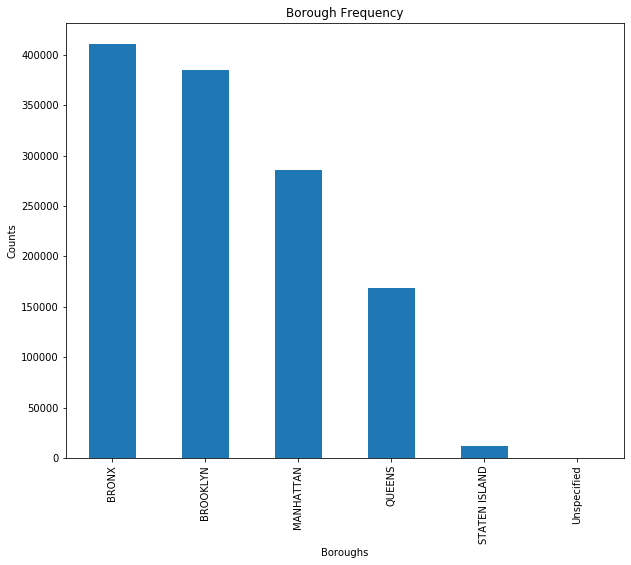

In [13]:
HBD_Boro.Borough.value_counts().plot(kind='bar', figsize=(10,8))
#
plt.xlabel('Boroughs')
plt.ylabel('Counts')
plt.title('Borough Frequency')
#
plt.show()

In [14]:
HBD_Boro.Street_Name.value_counts().head()

GRAND CONCOURSE    22287
BROADWAY           15368
ELMHURST AVENUE    11377
OCEAN AVENUE       10110
MORRIS AVENUE       9727
Name: Street_Name, dtype: int64

In [ ]:
HBD_Boro[HBD_Boro['Street_Name'] == 'GRAND CONCOURSE'].head()

It looks like the Borough with the most frequent complaints is the BRONX and not suprisingly the top most Street Names that called in the complaints is also in the Bronx as well

#### To VISUALIZE this I will map it out

In [50]:
import folium

In [51]:
# Create a map and display it
def generateBaseMap(default_location=[40.71, -74.00], default_zoom_start=12):
    nycmap = folium.Map(location=default_location, zoom_start=default_zoom_start)
    return nycmap


Now recall out missing data in this dataframe. Both Latitude and Longitude have missing data. Unfortunately we have no choice but to remove the missing data in order to map our occurances. 

In [52]:
HBD_Boro = HBD_Boro.dropna(subset=["Latitude"], axis=0)
HBD_Boro = HBD_Boro.dropna(subset=['Longitude'],axis=0)
HBD_Boro.isnull().sum()

Unique_Key          0
Created_Date        0
Complaint_Type      0
Incident_Zip        1
Incident Address    0
Street_Name         0
Borough             0
Latitude            0
Longitude           0
dtype: int64

In [53]:
number_of_occurances = pd.DataFrame(HBD_Boro.Created_Date.apply(lambda x: x.year))
number_of_occurances.rename(columns={"Created_Date": "Year_Created"}, inplace=True)
# number_of_occurances.reset_index(inplace=True)
number_of_occurances['Count'] = 1
number_of_occurances.head()

AttributeError: 'str' object has no attribute 'year'

In [ ]:
number_of_occurances = number_of_occurances.join(HBD_Boro)
number_of_occurances.head()

In [ ]:
from folium.plugins import HeatMap
nyc_map = generateBaseMap()
HeatMap(data=number_of_occurances[['Latitude', 'Longitude','Count']].groupby(['Latitude','Longitude']).sum().reset_index().values.tolist(),
                                                                                                                        radius=8,max_zoom=13).add_to(nyc_map)

In [ ]:
nyc_map

In [ ]:
nyc_map.add_child(folium.ClickForMarker(popup='Potential Location'))

Looking at the heat map we can see the areas of high concentration. Visually you can see theat the Bronx has the most consisting mapping of high concentration. 

Now that we have selected the Complaint Type we will be focusing along with the Borough that requires the most attention we will now move on to explore these characteristics further

# Identitfy Relationship between Building characteristics and Top Complaint Type

We are going to load in the Pluto Dataset. This dataset contains tax lot data files for over seventy data fields derived from extracts of mainframe data files maintained by the Department of City Planning(DCP), Department of Finance(DOF),Department of Citywide Administrative Services(DCAS), and from information contained in Llandmarks Preservation Commision(LPC)publications and website

## Data selection with Pluto

In [15]:
Orig_Pluto =pd.read_csv("pluto_20v3.csv")

C:\Users\const\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (17,18,20,22,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
Orig_Pluto.shape

(858979, 90)

We can see this dataset has 858,979 samples and 90 features. First off that's alot of features so we should investigate the Problem set to narrow those down. 

Since we are exploring the Bronx we will limit the data to reflect that. 

In [16]:
Pluto = Orig_Pluto[["address","lot","lotarea","bldgarea","resarea","numbldgs","numfloors",
                      "bldgdepth","yearbuilt","builtfar","residfar","commfar","facilfar",
                      "xcoord","ycoord","latitude","longitude","yearalter1",
                      "officearea","retailarea","zipcode","borough"]]

In [17]:
Pluto.isnull().sum()

address         465
lot               0
lotarea         621
bldgarea        474
resarea       48030
numbldgs        621
numfloors       621
bldgdepth       621
yearbuilt       465
builtfar        937
residfar        465
commfar         465
facilfar        465
xcoord         1419
ycoord         1419
latitude       1419
longitude      1419
yearalter1      465
officearea    48030
retailarea    48030
zipcode        2037
borough           0
dtype: int64

Need to be able to calculate Age from difference in years so there is a couple of steps we have to take. 

    1. Drop NAs so can convert to int
    2. Convert yearbuilt to int
    3. Calculate differene

In [18]:
Pluto = Pluto.dropna(subset=["yearbuilt"], axis=0)

In [19]:
Pluto.dtypes

address        object
lot             int64
lotarea       float64
bldgarea      float64
resarea       float64
numbldgs      float64
numfloors     float64
bldgdepth     float64
yearbuilt     float64
builtfar      float64
residfar      float64
commfar       float64
facilfar      float64
xcoord        float64
ycoord        float64
latitude      float64
longitude     float64
yearalter1    float64
officearea    float64
retailarea    float64
zipcode       float64
borough        object
dtype: object

There are also already some data type discrepencies that have to be attended to 

In [20]:
#Pluto['yearbuilt'] = pd.to_datetime(Pluto['yearbuilt'])
#Pluto['yearalter1'] = pd.to_datetime(Pluto['yearalter1'])
Pluto['yearbuilt'] =  Pluto['yearbuilt'].astype("int")
Pluto['yearalter1'] = Pluto['yearalter1'].astype("int")
    
Pluto['zipcode'] = Pluto['zipcode'].astype("str")
Pluto['lot'] = Pluto['lot'].astype("float64")

In [21]:
# We dropped NAs but we are also going to drop 0s
Pluto = Pluto[Pluto.yearbuilt != 0]

Pluto["Age"] = 2020 - Pluto["yearbuilt"]

Create new dataframe with the columns we are going to use

In [22]:
Pluto_v1 = Pluto[["address","lot","lotarea","bldgarea","resarea","numbldgs","numfloors",
                "bldgdepth","yearbuilt","yearalter1","builtfar","residfar","commfar","facilfar",
                  "officearea","retailarea","zipcode","Age", "borough"]]
Pluto_v1.head()

,address,lot,lotarea,bldgarea,resarea,numbldgs,numfloors,bldgdepth,yearbuilt,yearalter1,builtfar,residfar,commfar,facilfar,officearea,retailarea,zipcode,Age,borough
0,JOE DIMAGGIO HIGHWAY,401.0,246896.0,0.0,NaN,0.0,0.00,0.0,1949,0,0.00,0.0,0.0,0.0,NaN,NaN,nan,71,MN
7,146 2 AVENUE,1.0,9412.0,37353.0,30153.0,5.0,5.00,86.0,1900,2001,3.97,4.0,0.0,4.0,0.0,7200.0,10003.0,120,MN
10,243 MORELAND STREET,30.0,2807.0,1770.0,1770.0,1.0,2.00,50.0,2019,0,0.63,0.5,0.0,1.0,0.0,0.0,10306.0,1,SI
12,454 BEACH 125 STREET,70.0,4000.0,1286.0,1286.0,1.0,1.67,36.0,1950,0,0.32,0.5,0.0,1.0,0.0,0.0,11694.0,70,QN
13,460 BEACH 125 STREET,72.0,5000.0,2352.0,1344.0,1.0,1.00,55.0,1970,0,0.47,0.5,0.0,1.0,0.0,0.0,11694.0,50,QN


In [33]:
Pluto_v1.shape

(816441, 17)

In [23]:
Pluto_v1.isnull().sum()

address          0
lot              0
lotarea          0
bldgarea         2
resarea       7137
numbldgs         0
numfloors        0
bldgdepth        0
yearbuilt        0
yearalter1       0
builtfar         9
residfar         0
commfar          0
facilfar         0
officearea    7137
retailarea    7137
zipcode          0
Age              0
borough          0
dtype: int64

So there are a decent amount of missing values. Since I will be merging data I want to minimize any problems that might occur from these missing values.

We have two options to drop the missing values or to replace the missing values. The three largest missing values is ResArea, OfficeArea and RetailArea

will replace the 0s with the mean of that column and nans so it will be **resarea, officearea, retailarea and builtfar** that we will replace NANs

In [13]:
Pluto_v1.columns.unique()

Index(['address', 'lot', 'lotarea', 'bldgarea', 'resarea', 'numbldgs',
       'numfloors', 'bldgdepth', 'yearbuilt', 'builtfar', 'residfar',
       'commfar', 'facilfar', 'officearea', 'retailarea', 'zipcode', 'Age',
       'Age_Alter', 'borough'],
      dtype='object')

In [127]:
Pluto_v1.to_csv('Pluto_v1.csv')

#### So no create new dataframe from the borough we will be focusing on

In [24]:
Pluto_BX = Pluto_v1[(Pluto_v1['borough'] == 'BX')]

In [25]:
Pluto_BX.head()

,address,lot,lotarea,bldgarea,resarea,numbldgs,numfloors,bldgdepth,yearbuilt,yearalter1,builtfar,residfar,commfar,facilfar,officearea,retailarea,zipcode,Age,borough
138,1516 ASTOR AVENUE,27.0,3034.0,2660.0,2660.0,2.0,2.0,36.0,1945,0,0.88,0.75,0.0,2.0,0.0,0.0,10469.0,75,BX
156,2237 WOODHULL AVENUE,28.0,3208.0,1888.0,1392.0,1.0,1.5,31.0,1950,0,0.59,0.75,0.0,2.0,0.0,0.0,10469.0,70,BX
410,919 CRANFORD AVENUE,12.0,3000.0,2244.0,2244.0,2.0,2.0,51.0,1915,0,0.75,0.75,0.0,2.0,0.0,0.0,10466.0,105,BX
411,903 CRANFORD AVENUE,18.0,2700.0,1344.0,1344.0,2.0,2.5,38.0,1925,0,0.50,0.75,0.0,2.0,0.0,0.0,10466.0,95,BX
615,443 WEST 259 STREET,569.0,3242.0,1810.0,1810.0,1.0,2.5,35.0,1920,0,0.56,0.50,0.0,1.0,0.0,0.0,10471.0,100,BX


In [26]:
Pluto_BX.drop(['borough'],axis=1, inplace=True)

C:\Users\const\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
Pluto_BX.shape

(83391, 18)

Lets drop the duplicates that will be in our dataframe

In [69]:
Pluto_BX.drop_duplicates().head()

,address,lot,lotarea,bldgarea,resarea,numbldgs,numfloors,bldgdepth,yearbuilt,builtfar,residfar,commfar,facilfar,officearea,retailarea,zipcode,Age
138,1516 ASTOR AVENUE,27.00,3034.00,2660.00,2660.00,2.00,2.00,36.00,1945,0.88,0.75,0.00,2.00,0.00,0.00,10469.0,75
156,2237 WOODHULL AVENUE,28.00,3208.00,1888.00,1392.00,1.00,1.50,31.00,1950,0.59,0.75,0.00,2.00,0.00,0.00,10469.0,70
410,919 CRANFORD AVENUE,12.00,3000.00,2244.00,2244.00,2.00,2.00,51.00,1915,0.75,0.75,0.00,2.00,0.00,0.00,10466.0,105
411,903 CRANFORD AVENUE,18.00,2700.00,1344.00,1344.00,2.00,2.50,38.00,1925,0.50,0.75,0.00,2.00,0.00,0.00,10466.0,95
615,443 WEST 259 STREET,569.00,3242.00,1810.00,1810.00,1.00,2.50,35.00,1920,0.56,0.50,0.00,1.00,0.00,0.00,10471.0,100


In [70]:
Pluto_BX.shape

(83391, 17)

Lets look at the missing data now and sum them

In [71]:
Pluto_BX.isnull().sum()

address         0
lot             0
lotarea         0
bldgarea        0
resarea       894
numbldgs        0
numfloors       0
bldgdepth       0
yearbuilt       0
builtfar        0
residfar        0
commfar         0
facilfar        0
officearea    894
retailarea    894
zipcode         0
Age             0
dtype: int64

In [28]:
#Change format of how float is displayed
pd.options.display.float_format = "{:.2f}".format

In [73]:
Pluto_BX['resarea'].describe()

count      82497.00
mean        6124.73
std        57465.18
min            0.00
25%         1280.00
50%         1892.00
75%         2709.00
max     13211398.00
Name: resarea, dtype: float64

 There is a huge disparity between the min and max. The best option here is to normalize the data. I will normalize this during the prediction process using scikitLearn.

Since we are exploring characteristics of buildings to our complaint type we will be grouping the data by zipcode which is shared by both datasets. Then we wil revisit this issue.

In [ ]:
#Pluto_BX.zipcode.value_counts()

In [ ]:
#Pdf_grp = Pluto_BX.groupby(['zipcode'],as_index=False).mean()
#Pdf_grp.head()

So now that we have our pluto dataset it's time to compare this data to the data from The Housing Department of Preservation and Development. 

First thing we will do is merge the two datasets to get a better look. We will merge them by the common column, zip code

#### The Housing Department of Preservation and Development

In [29]:
HBD_BX = HBD[(HBD['Complaint_Type'] == 'HEAT/HOT WATER')]

In [30]:
HBD_BX = HBD_BX[(HBD_BX['Borough'] == 'BRONX')]
HBD_BX.head()

,Unnamed: 0,Unique_Key,Created_Date,Closed_Date,Complaint_Type,Location_Type,Incident_Zip,Incident Address,Street_Name,Address_Type,City,Status,Resolution Description,Borough,Latitude,Longitude
3,3,45530329,02/02/2020 12:13:18 PM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10458.00,2405 SOUTHERN BOULEVARD,SOUTHERN BOULEVARD,ADDRESS,BRONX,Open,The following complaint conditions are still o...,BRONX,40.85,-73.88
5,5,45530344,02/02/2020 07:52:08 AM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10456.00,1131 MORRIS AVENUE,MORRIS AVENUE,ADDRESS,BRONX,Open,The following complaint conditions are still o...,BRONX,40.83,-73.92
10,10,45530349,02/02/2020 05:38:39 AM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10459.00,1032 ALDUS STREET,ALDUS STREET,ADDRESS,BRONX,Open,The following complaint conditions are still o...,BRONX,40.82,-73.89
19,19,45529362,02/02/2020 01:38:25 PM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10473.00,880 BOYNTON AVENUE,BOYNTON AVENUE,ADDRESS,BRONX,Open,The complaint you filed is a duplicate of a co...,BRONX,40.82,-73.88
29,29,45528454,02/02/2020 10:25:32 PM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10463.00,3110 KINGSBRIDGE TERRACE,KINGSBRIDGE TERRACE,ADDRESS,BRONX,Open,The complaint you filed is a duplicate of a co...,BRONX,40.88,-73.90


In [34]:
HBD_BX = HBD_BX.drop(['Unnamed: 0','Unique_Key','Closed_Date','Created_Date',
               'Status','Resolution Description','City','Address_Type','Borough'],axis=1)

In [35]:
HBD_BX.dtypes

Complaint_Type       object
Location_Type        object
Incident_Zip        float64
Incident Address     object
Street_Name          object
Latitude            float64
Longitude           float64
dtype: object

In [36]:
HBD_BX.isnull().sum()

Complaint_Type         0
Location_Type          0
Incident_Zip        1883
Incident Address       0
Street_Name            0
Latitude            1883
Longitude           1883
dtype: int64

Since we will be merging on Address we will make sure there are no null values there.

In [37]:
HBD_BX['Incident_Zip'] = HBD_BX['Incident_Zip'].astype("str")
HBD_BX.rename(columns={"Incident_Zip": "zipcode"}, inplace=True)
HBD_BX.rename(columns={"Incident Address": "address"}, inplace=True)

In [38]:
HBD_BX['count'] = HBD_BX.groupby(['address'])['Complaint_Type'].transform('count')

In [39]:
HBD_BX.dropna(subset=["address"], axis=0, inplace=True)

In [40]:
HBD_BX.head()

,Complaint_Type,Location_Type,zipcode,address,Street_Name,Latitude,Longitude,count
3,HEAT/HOT WATER,RESIDENTIAL BUILDING,10458.0,2405 SOUTHERN BOULEVARD,SOUTHERN BOULEVARD,40.85,-73.88,138
5,HEAT/HOT WATER,RESIDENTIAL BUILDING,10456.0,1131 MORRIS AVENUE,MORRIS AVENUE,40.83,-73.92,266
10,HEAT/HOT WATER,RESIDENTIAL BUILDING,10459.0,1032 ALDUS STREET,ALDUS STREET,40.82,-73.89,74
19,HEAT/HOT WATER,RESIDENTIAL BUILDING,10473.0,880 BOYNTON AVENUE,BOYNTON AVENUE,40.82,-73.88,332
29,HEAT/HOT WATER,RESIDENTIAL BUILDING,10463.0,3110 KINGSBRIDGE TERRACE,KINGSBRIDGE TERRACE,40.88,-73.90,359


In [ ]:
#HBD_BX.drop_duplicates(subset="zipcode",keep="first", inplace=True)
## this was when I was grouping by zipcode

#### Merging the two dataframes together

In [41]:
HBD_BX_Pluto = pd.merge( left=Pluto_BX, right=HBD_BX, how='inner', on='address')
HBD_BX_Pluto.head()

,address,lot,lotarea,bldgarea,resarea,numbldgs,numfloors,bldgdepth,yearbuilt,yearalter1,...,retailarea,zipcode_x,Age,Complaint_Type,Location_Type,zipcode_y,Street_Name,Latitude,Longitude,count
0,953 ANDERSON AVENUE,34.00,11849.00,45000.00,45000.00,2.00,5.00,95.00,1917,1983,...,0.00,10452.0,103,HEAT/HOT WATER,RESIDENTIAL BUILDING,10452.0,ANDERSON AVENUE,40.83,-73.93,122
1,953 ANDERSON AVENUE,34.00,11849.00,45000.00,45000.00,2.00,5.00,95.00,1917,1983,...,0.00,10452.0,103,HEAT/HOT WATER,RESIDENTIAL BUILDING,10452.0,ANDERSON AVENUE,40.83,-73.93,122
2,953 ANDERSON AVENUE,34.00,11849.00,45000.00,45000.00,2.00,5.00,95.00,1917,1983,...,0.00,10452.0,103,HEAT/HOT WATER,RESIDENTIAL BUILDING,10452.0,ANDERSON AVENUE,40.83,-73.93,122
3,953 ANDERSON AVENUE,34.00,11849.00,45000.00,45000.00,2.00,5.00,95.00,1917,1983,...,0.00,10452.0,103,HEAT/HOT WATER,RESIDENTIAL BUILDING,10452.0,ANDERSON AVENUE,40.83,-73.93,122
4,953 ANDERSON AVENUE,34.00,11849.00,45000.00,45000.00,2.00,5.00,95.00,1917,1983,...,0.00,10452.0,103,HEAT/HOT WATER,RESIDENTIAL BUILDING,10452.0,ANDERSON AVENUE,40.83,-73.93,122


In [42]:
HBD_BX_Pluto.head()

,address,lot,lotarea,bldgarea,resarea,numbldgs,numfloors,bldgdepth,yearbuilt,yearalter1,...,retailarea,zipcode_x,Age,Complaint_Type,Location_Type,zipcode_y,Street_Name,Latitude,Longitude,count
0,953 ANDERSON AVENUE,34.00,11849.00,45000.00,45000.00,2.00,5.00,95.00,1917,1983,...,0.00,10452.0,103,HEAT/HOT WATER,RESIDENTIAL BUILDING,10452.0,ANDERSON AVENUE,40.83,-73.93,122
1,953 ANDERSON AVENUE,34.00,11849.00,45000.00,45000.00,2.00,5.00,95.00,1917,1983,...,0.00,10452.0,103,HEAT/HOT WATER,RESIDENTIAL BUILDING,10452.0,ANDERSON AVENUE,40.83,-73.93,122
2,953 ANDERSON AVENUE,34.00,11849.00,45000.00,45000.00,2.00,5.00,95.00,1917,1983,...,0.00,10452.0,103,HEAT/HOT WATER,RESIDENTIAL BUILDING,10452.0,ANDERSON AVENUE,40.83,-73.93,122
3,953 ANDERSON AVENUE,34.00,11849.00,45000.00,45000.00,2.00,5.00,95.00,1917,1983,...,0.00,10452.0,103,HEAT/HOT WATER,RESIDENTIAL BUILDING,10452.0,ANDERSON AVENUE,40.83,-73.93,122
4,953 ANDERSON AVENUE,34.00,11849.00,45000.00,45000.00,2.00,5.00,95.00,1917,1983,...,0.00,10452.0,103,HEAT/HOT WATER,RESIDENTIAL BUILDING,10452.0,ANDERSON AVENUE,40.83,-73.93,122


In [43]:
HBD_BX_Pluto.drop_duplicates(subset='address',keep="first",inplace=True)

Looking at the dataframeLooking at the dataframe it doesn't look like yearbuilt or yearalter is going to be much help since we calculated the age already. 

Since we have data for residential areas and retail areas and commercial areas lets actually see what kind of Location type we are dealing with

In [44]:
HBD_BX_Pluto.Location_Type.value_counts()

RESIDENTIAL BUILDING    13740
Name: Location_Type, dtype: int64

As we can see here `Location_Type` is predominantly Residential. 

In [275]:
HBD_BX_Pluto.columns.unique()

Index(['address', 'lot', 'lotarea', 'bldgarea', 'resarea', 'numbldgs',
       'numfloors', 'bldgdepth', 'yearbuilt', 'builtfar', 'residfar',
       'commfar', 'facilfar', 'officearea', 'retailarea', 'zipcode_x', 'Age',
       'Age_Alter', 'Complaint_Type', 'Location_Type', 'zipcode_y',
       'Street_Name', 'Latitude', 'Longitude', 'count'],
      dtype='object')

So it looks like we are dealing with With residential that elimunates `commfar`,`facilfar`, `officearea`,`retailarea`

In [45]:
HBD_BX_Pluto.drop(['commfar','facilfar','officearea','retailarea'],axis=1,inplace=True)

We also don't need yearbuilt but maybe we can do something with yearbuilt

In [520]:
HBD_BX_Pluto.drop(['yearbuilt'],axis=1,inplace=True)

In [46]:
HBD_BX_Pluto.drop(['Longitude','Latitude'],axis=1,inplace=True)

And since we are looking at data already in the Bronx I do not think `Latitude` and `Longitude` are essential.

In [60]:
#Save file
HBD_BX_Pluto.to_csv("HBD_BX_Pluto.csv")

In [53]:
Pdf_grp = HBD_BX_Pluto.groupby(['zipcode_x'],as_index=False).mean()
Pdf_grp.head()

,zipcode_x,lot,lotarea,bldgarea,resarea,numbldgs,numfloors,bldgdepth,yearbuilt,yearalter1,builtfar,residfar,Age,count
0,10451.0,389.34,12810.42,50703.47,45165.34,1.12,5.23,83.64,1939.60,718.63,3.46,4.15,80.40,41.29
1,10452.0,82.94,12072.37,43506.93,40902.46,1.15,4.98,83.89,1936.13,792.25,3.49,4.44,83.87,38.35
2,10453.0,97.33,8781.03,31391.52,29247.13,1.09,4.58,76.70,1933.35,642.04,3.08,4.03,86.65,41.73
3,10454.0,66.61,7361.06,23496.02,21579.48,1.25,4.63,73.64,1928.25,888.02,3.20,2.42,91.75,10.19
4,10455.0,210.07,6806.73,20636.05,17617.62,1.09,4.24,76.71,1929.15,737.59,2.81,3.10,90.85,17.58


In [59]:
Pdf_grp.shape

(26, 14)

## Time to look at Correlation

(0, 49.227986807957244)

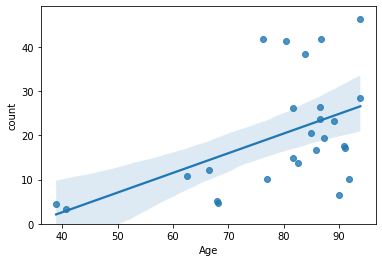

In [58]:
sns.regplot(x="Age", y="count", data=Pdf_grp)
plt.ylim(0,)

There is some correlation of resarea and amount of complaints

(0, 48.843187813606285)

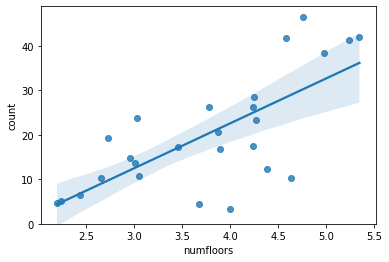

In [55]:
sns.regplot(x="numfloors", y="count", data=Pdf_grp)
plt.ylim(0,)

There seems to be a high positive linear correlation between numfloors and amount of complaints

(0, 49.17548392967979)

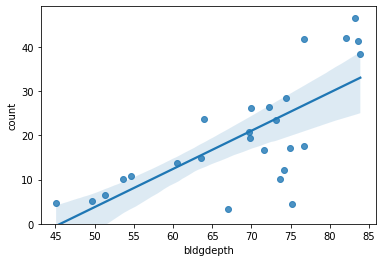

In [56]:
sns.regplot(x="bldgdepth", y="count", data=Pdf_grp)
plt.ylim(0,)

There seems to be some correlation between bldgdepth and amount of complaints

Doesn't look like there is a linear correlation between the variables

#### USING PEARSON'S CORRELATION

In [61]:
HBD_Exp = pd.read_csv("HBD_BX_Pluto.csv")

In [80]:
HBD_Exp.replace(0, np.nan, inplace=True)
HBD_Exp.replace('nan', np.nan, inplace=True)

In [83]:
HBD_Exp.isnull().sum()

Unnamed: 0        0
address           0
lot               0
lotarea           0
bldgarea          0
resarea           0
numbldgs          0
numfloors         0
bldgdepth         0
yearbuilt         0
yearalter1        0
builtfar          0
residfar          0
zipcode_x         0
Age               0
Complaint_Type    0
Location_Type     0
zipcode_y         0
Street_Name       0
count             0
dtype: int64

In [82]:
HBD_Exp.fillna(HBD_Exp.mean(), inplace=True)

In [84]:
HBD_Exp.drop(['Unnamed: 0','zipcode_x', 'zipcode_y'],axis=1,inplace=True)

In [126]:
HBD_Exp.head()

,address,lot,lotarea,bldgarea,resarea,numbldgs,numfloors,bldgdepth,yearbuilt,yearalter1,builtfar,residfar,Age,Complaint_Type,Location_Type,Street_Name,count
2,3311 PARKSIDE PLACE,153.00,2250.00,2592.00,2024.00,1.00,2.00,60.00,1920,1997.10,1.15,3.00,100,HEAT/HOT WATER,RESIDENTIAL BUILDING,PARKSIDE PLACE,9.00
3,16 LANE AVENUE,21.00,2514.00,3950.00,20495.55,1.00,2.00,70.00,1931,1997.10,1.57,2.43,89,HEAT/HOT WATER,RESIDENTIAL BUILDING,LANE AVENUE,1.00
4,1056 SHERIDAN AVENUE,36.00,4000.00,17600.00,17600.00,1.00,5.00,88.00,1918,1992.00,4.40,3.44,102,HEAT/HOT WATER,RESIDENTIAL BUILDING,SHERIDAN AVENUE,6.00
5,1060 SHERIDAN AVENUE,37.00,8090.00,30385.00,30385.00,1.00,5.00,88.00,1918,1991.00,3.76,3.44,102,HEAT/HOT WATER,RESIDENTIAL BUILDING,SHERIDAN AVENUE,53.00
6,50 WEST 182 STREET,56.00,5000.00,29274.00,29274.00,1.00,6.00,90.00,1935,1997.10,5.85,3.44,85,HEAT/HOT WATER,RESIDENTIAL BUILDING,WEST 182 STREET,7.00


In [128]:
HBD_Exp.corr(method="pearson")

,lot,lotarea,bldgarea,resarea,numbldgs,numfloors,bldgdepth,yearbuilt,yearalter1,builtfar,residfar,Age,count
lot,1.00,0.15,0.17,0.13,nan,0.16,0.06,0.18,0.04,0.10,0.04,-0.18,-0.01
lotarea,0.15,1.00,0.81,0.75,nan,0.56,0.51,0.11,-0.03,0.27,0.18,-0.11,0.16
bldgarea,0.17,0.81,1.00,0.95,nan,0.78,0.57,0.08,-0.04,0.59,0.32,-0.08,0.24
resarea,0.13,0.75,0.95,1.00,nan,0.79,0.55,0.07,-0.06,0.59,0.34,-0.07,0.26
numbldgs,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
numfloors,0.16,0.56,0.78,0.79,nan,1.00,0.49,0.09,-0.05,0.77,0.42,-0.09,0.22
bldgdepth,0.06,0.51,0.57,0.55,nan,0.49,1.00,-0.12,-0.09,0.54,0.34,0.12,0.19
yearbuilt,0.18,0.11,0.08,0.07,nan,0.09,-0.12,1.00,0.09,-0.08,-0.14,-1.00,-0.04
yearalter1,0.04,-0.03,-0.04,-0.06,nan,-0.05,-0.09,0.09,1.00,-0.09,-0.03,-0.09,-0.04
builtfar,0.10,0.27,0.59,0.59,nan,0.77,0.54,-0.08,-0.09,1.00,0.49,0.08,0.23


In [99]:
buildings_high = HBD_Exp[HBD_Exp['numbldgs'] > 1.00]
building_one = HBD_Exp[HBD_Exp['numbldgs'] <=1.00]

In [98]:
buildings_high['numbldgs'].count()

1849

In [101]:
building_one['numbldgs'].count()

11891

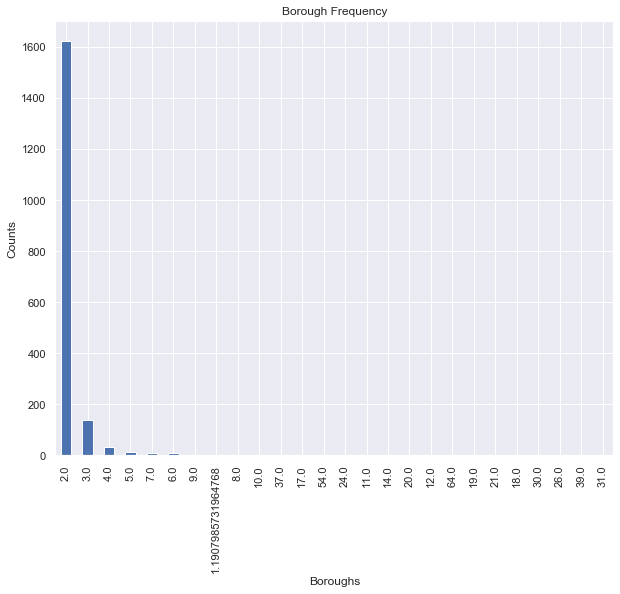

In [96]:
buildings.numbldgs.value_counts().plot(kind='bar', figsize=(10,8))
#
plt.xlabel('Boroughs')
plt.ylabel('Counts')
plt.title('Borough Frequency')
#
plt.show()

We can conclude that there seems to be a distortion in data due to recording of data for more that one building. To mitigate this we will remove data with recording for more than one data.

In [125]:
HBD_Exp.drop(HBD_Exp[HBD_Exp['numbldgs'] > 1.00].index, inplace = True) 
HBD_Exp['numbldgs'].count()

11891

#### Looking at SKEWED Data

In [129]:
cols = HBD_Exp[['lot','lotarea','bldgarea','resarea','numbldgs','numfloors',
                'bldgdepth','builtfar','residfar','Age','count']]

In [130]:
sns.set(rc={"figure.figsize": (8, 4)})
sns.distplot(lot, kde=True)

NameError: name 'lot' is not defined

In [131]:
HBD_Exp['resarea'].describe()

count    11891.00
mean     19482.41
std      30896.56
min        392.00
25%       2436.00
50%       4784.00
75%      24090.00
max     631178.00
Name: resarea, dtype: float64

In [133]:
HBD_Exp[''].skew()

4.724906549554139

In [69]:
import math
from scipy import stats
count = np.log((HBD_Exp['count']**2)+1)
count = normalize(count)
count.skew()

NameError: name 'normalize' is not defined

In [70]:
HBD_Exp[HBD_Exp['count'] < 10000].head().count()

Unnamed: 0        5
address           5
lot               5
lotarea           5
bldgarea          5
resarea           5
numbldgs          5
numfloors         5
bldgdepth         5
yearbuilt         5
yearalter1        5
builtfar          5
residfar          5
zipcode_x         5
Age               5
Complaint_Type    5
Location_Type     5
zipcode_y         5
Street_Name       5
count             5
dtype: int64

In [ ]:
def sigmoid(x):
    e = np.exp(1)
    y = 1/(1+e**(-x))
    return y

In [119]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

In [120]:
HBD_Exp['count'] = HBD_Exp['count'].astype("float")

In [134]:
cols_to_norm = HBD_Exp[['lotarea','bldgarea','resarea','numfloors',
                'bldgdepth','builtfar','residfar','count']]
cols_to_norm = cols_to_norm.apply(lambda x: (np.log(x**2)+1))

In [135]:
cols_to_norm = cols_to_norm.apply(lambda x: (normalize(x)))
cols_to_norm

,lotarea,bldgarea,resarea,numfloors,bldgdepth,builtfar,residfar,count
2,0.21,0.31,0.22,0.20,0.42,0.60,0.60,0.26
3,0.23,0.36,0.54,0.20,0.45,0.63,0.53,0.00
4,0.30,0.54,0.52,0.47,0.51,0.76,0.64,0.21
5,0.42,0.60,0.59,0.47,0.51,0.74,0.64,0.46
6,0.34,0.60,0.58,0.53,0.51,0.80,0.64,0.23
...,...,...,...,...,...,...,...,...
13733,0.32,0.46,0.43,0.53,0.36,0.67,0.60,0.08
13734,0.23,0.34,0.29,0.20,0.48,0.60,0.31,0.00
13736,0.14,0.27,0.22,0.20,0.38,0.61,0.26,0.00
13737,0.23,0.28,0.23,0.30,0.37,0.55,0.31,0.00


In [136]:
cols_to_norm.corr(method="pearson")

,lotarea,bldgarea,resarea,numfloors,bldgdepth,builtfar,residfar,count
lotarea,1.00,0.89,0.87,0.66,0.64,0.51,0.33,0.51
bldgarea,0.89,1.00,0.97,0.86,0.75,0.85,0.49,0.61
resarea,0.87,0.97,1.00,0.84,0.74,0.82,0.51,0.61
numfloors,0.66,0.86,0.84,1.00,0.56,0.85,0.49,0.56
bldgdepth,0.64,0.75,0.74,0.56,1.00,0.66,0.42,0.46
builtfar,0.51,0.85,0.82,0.85,0.66,1.00,0.55,0.56
residfar,0.33,0.49,0.51,0.49,0.42,0.55,1.00,0.33
count,0.51,0.61,0.61,0.56,0.46,0.56,0.33,1.00


In [138]:
cols_to_norm['count'].describe()

count   11891.00
mean        0.20
std         0.18
min         0.00
25%         0.00
50%         0.16
75%         0.33
max         1.00
Name: count, dtype: float64

So after transfroming the data and normalizing it we can see the number of complaints still has a low correlation to the other features. THe only stand out is with residfar at .46 correlation.